In [29]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers , models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [30]:
# Path to NASA spectrogram files
NASA_spectrogram_root_folder = r"../data/NASA"

In [31]:
# Names of NASA training files
file_names = [
    "3_channel_2.mat",
    "1_channel_4.mat",
    "2_channel_0.mat"
]
# Indices indicating where faults start in each of the provided files.
fault_start_indices = [6071, 1975, 701]

input_files = [os.path.join(NASA_spectrogram_root_folder, file_name_) for file_name_ in file_names]

# Names of NASA benchmark files
file_names_test = [
    "1_channel_6.mat",
]
# Prepare test data from a specific file along with its fault start index.
test_fault_start_index = 1616 

test_file = os.path.join(NASA_spectrogram_root_folder, file_names_test[0])

In [32]:
# Swish activation function
def swish(x):
    return x * tf.nn.sigmoid(x)

# Function to downsample the y-axis (frequency axis) of a spectrogram
def downsample_spectrogram_y_axis(spectrogram, downsample_factor):
    return spectrogram[::downsample_factor, :]
    
#  Function to load and process the test file including spectrogram processing
def prepare_test_data(test_file, fault_start_index, downsample_factor, slice_width, std_num):
    
    # Load the spectrogram
    mat_contents = scipy.io.loadmat(test_file)
    spectrogram = mat_contents['spectrogram']

    # Process the spectrogram
    avg_y = np.mean(spectrogram)
    std_y = np.std(spectrogram)
    clean_y = np.clip(spectrogram, avg_y - std_num * std_y, avg_y + std_num * std_y)
    clean_y_min = np.min(clean_y)
    clean_y_max = np.max(clean_y)
    norm_y = (clean_y - clean_y_min) / (clean_y_max - clean_y_min)

    # Downsample processed spectrogram along the y-axis
    norm_y_downsampled = downsample_spectrogram_y_axis(norm_y, downsample_factor)
    data_list, labels = [], []  #  data and labels 
    num_slices = norm_y_downsampled.shape[1] // slice_width
    
    for i in range(num_slices):
        start_index = i * slice_width
        end_index = start_index + slice_width
        time_slice = norm_y_downsampled[:, start_index:end_index]
        
        # Reshape to match the input shape expected by the model
        time_slice_reshaped = time_slice[np.newaxis, :, :, np.newaxis]
        
        # Append data and label
        data_list.append(time_slice_reshaped)
        label = 1 if start_index >= fault_start_index else 0
        labels.append(label)

    # Combine data and labels
    combined_data = np.concatenate(data_list, axis=0)
    reshaped_data = np.transpose(combined_data,(0,2,1,3))
    combined_labels = np.array(labels)
    return reshaped_data, combined_labels


def load_and_split_data(file_paths, fault_start_indices, downsample_factor, slice_width, std_num):
    data_list = []
    labels = []  # 0 for non-faulty, 1 for faulty
    
    for file_index, file_path in enumerate(file_paths):
        # Load the spectrogram
        mat_contents = scipy.io.loadmat(file_path)
        spectrogram = mat_contents['spectrogram']
        
        # Process the spectrogram before downsampling
        avg_y = np.mean(spectrogram)
        std_y = np.std(spectrogram)
        clean_y = np.clip(spectrogram, avg_y - std_num * std_y, avg_y + std_num * std_y)
        clean_y_min = np.min(clean_y)
        clean_y_max = np.max(clean_y)
        norm_y = (clean_y - clean_y_min) / (clean_y_max - clean_y_min)

        # Downsample the processed spectrogram along the y-axis
        norm_y_downsampled = downsample_spectrogram_y_axis(norm_y, downsample_factor)
        
        # Calculate the number of slices based on the slice width
        num_slices = norm_y_downsampled.shape[1] // slice_width
        
        for i in range(num_slices):
            start_index = i * slice_width
            end_index = start_index + slice_width
            time_slice = norm_y_downsampled[:, start_index:end_index]
            
            # Flatten or transform the slice for SMOTE compatibility (placeholder)
            
            
            # Append data and label
            data_list.append(time_slice)
            label = 1 if start_index >= fault_start_indices[file_index] else 0
            labels.append(label)
    
    comb_labels = np.array(labels)
    data_array = np.array(data_list)
    reshaped_dim = np.transpose(data_array, (0,2,1))
    

    return reshaped_dim, comb_labels





# Set the activation function to be used in the model. funcitons used: "relu", "gelu" and Swish
activation = "relu"

# Factor by which to downsample the spectrogram data for easier processing.
downsample_factor = 20  

# Width of each data slice to be used for training the model.
slice_width = 3

# Standard deviation factor for data normalization.
std = 3

# Length of each sequence input to the model, set equal to slice width.
sequence_length = slice_width

# Load and preprocess data from specified files, returning combined data and labels.
combined_data, combined_labels = load_and_split_data(input_files, fault_start_indices, downsample_factor, slice_width, std)

# Extract data points labeled as non-faulty.
no_fault_data = combined_data[combined_labels == 0]

# Extract data points labeled as faulty.
faulty_data = combined_data[combined_labels == 1]

test_data, test_labels = prepare_test_data(test_file, test_fault_start_index, downsample_factor, slice_width, std)

# Generate labels for the no fault data as 0 (indicating non-faulty).
y_no_fault = np.zeros(len(no_fault_data))

# Generate labels for the faulty data as 1 (indicating faulty).
y_faulty = np.ones(len(faulty_data))

# Combine the no fault and faulty data into a single dataset.
X = np.concatenate([no_fault_data, faulty_data], axis=0)

# Combine the labels for no fault and faulty data.
y = np.concatenate([y_no_fault, y_faulty])

# Split the combined dataset into training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert labels to numpy array if they are TensorFlow tensors, ensuring compatibility.
y_train_np = y_train.numpy() if isinstance(y_train, tf.Tensor) else y_train

# Convert datasets to TensorFlow tensors to facilitate model training.
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)



# Build Transformer model
def build_transformer(sequence_length, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout_rate, embedding_dim):
    # Input layer specifying shape according to provided sequence length and embedding dimension
    inputs = keras.Input(shape=(sequence_length, embedding_dim))
    # Dense layer to project inputs to a higher-dimensional space defined by ff_dim
    x = layers.Dense(ff_dim, activation='relu')(inputs)  # ReLU activation function

    # Positional encoding to the input features
    x = PositionalEncoding(sequence_length, ff_dim)(x)
    
    # Transformer blocks
    for _ in range(num_transformer_blocks):
        # Multi-head self-attention mechanism
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim, dropout=dropout_rate)(x, x)
        # Layer normalization after adding the attention output to the input of the block
        x = layers.LayerNormalization(epsilon=1e-6)(x + attention_output)
        
        # Feed-forward network within the transformer block
        ff_output = layers.Dense(ff_dim, activation='relu')(x)  # ReLU activation function

        ff_output = layers.Dropout(dropout_rate)(ff_output)
        ff_output = layers.Dense(ff_dim)(ff_output)
        # Layer normalization after adding the feed-forward network output to the block input
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Global average pooling to reduce the sequence dimension before the final classification layer
    x = layers.GlobalAveragePooling1D()(x)
    
    # Additional MLP units for further processing
    for units in mlp_units:
        x = layers.Dense(units, activation='relu')(x)  # ReLU activation function

        x = layers.Dropout(dropout_rate)(x)

    # Final output layer with a sigmoid activation for binary classification
    outputs = layers.Dense(1, activation="sigmoid")(x)  

    # Construct and return the Keras model
    return models.Model(inputs, outputs)
    
# PositionalEncoding class to add positional information to the inputs
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, embedding_dim, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.pos_encoding = self.positional_encoding(sequence_length, embedding_dim)
    
    def get_angles(self, position, i, embedding_dim):
        angles = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embedding_dim))
        return position * angles

    def positional_encoding(self, sequence_length, embedding_dim):
        angle_rads = self.get_angles(np.arange(sequence_length)[:, np.newaxis],
                                     np.arange(embedding_dim)[np.newaxis, :],
                                     embedding_dim)
        
        # Apply sin to even indices; 2i
        sines = np.sin(angle_rads[:, 0::2])
        
        # Apply cos to odd indices; 2i+1
        cosines = np.cos(angle_rads[:, 1::2])
        
        pos_encoding = np.concatenate([sines, cosines], axis=-1)[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
        
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


# Convert test dataset into TensorFlow tensors
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

# Remove an extra dimension from test data if present (beacuse the data has an unnecessary depth of 1)
test_data = np.squeeze(test_data, axis=-1)

# Set a threshold for binary classification
threshold = 0.5

# Example model parameters for the Transformer
num_heads = 4  # Number of attention heads
ff_dim = 256  # Dimension of the feed-forward layer
num_transformer_blocks = 3  # Number of transformer blocks
mlp_units = [128, 64]  # Number of units in the MLP (Dense) layers at the top of the model
dropout_rate = 0.3  # Dropout rate used in dropout layers within the Transformer and top MLP
embedding_dim = 10240 // downsample_factor  # Calculate embedding dimension as a factor of some dimension size

# Learning rate reduction setup to improve convergence
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=10, 
    min_lr=0.00001, 
    verbose=0  
)

# Function to build and train the model, and evaluate its performance
def build_and_train_model(X_train, y_train, X_val, y_val, test_data, test_labels):
    # Build the transformer model
    model = build_transformer(sequence_length, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout_rate, embedding_dim)
    # Compile the model with binary crossentropy loss and accuracy metric
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=["accuracy"])

    # Train the model(batch size and epoch are decided here)
    history = model.fit(X_train, y_train, callbacks=[reduce_lr], batch_size=64, epochs=40, validation_data=(X_val, y_val), verbose=1)

    # Predict on the training data and calculate accuracy and F1 score
    train_predictions = model.predict(X_train)
    train_predicted_labels = (train_predictions > threshold).astype(int)
    train_accuracy = accuracy_score(y_train, train_predicted_labels)
    train_f1_score = f1_score(y_train, train_predicted_labels, average='binary')

    # Predict on the test data and calculate accuracy and F1 score
    test_predictions = model.predict(test_data)
    test_predicted_labels = (test_predictions > threshold).astype(int)
    test_accuracy = accuracy_score(test_labels, test_predicted_labels)
    test_f1_score = f1_score(test_labels, test_predicted_labels, average='binary')

    return train_accuracy, train_f1_score, test_accuracy, test_f1_score, history, test_predicted_labels

# Initialize lists to store scores from multiple runs
train_accuracies = []
train_f1_scores = []
test_accuracies = []
test_f1_scores = []

# Number of runs for model evaluation
n_runs = 1

# Repeatedly run the training and evaluation to gather statistics
for _ in range(n_runs):
    ta, tf1, tsta, tstf1, history, test_predicted_labels = build_and_train_model(X_train, y_train, X_val, y_val, test_data, test_labels)
    train_accuracies.append(ta)
    train_f1_scores.append(tf1)
    test_accuracies.append(tsta)
    test_f1_scores.append(tstf1)

# Calculate and print the average of each metric across runs
avg_train_accuracy = np.mean(train_accuracies)
avg_train_f1_score = np.mean(train_f1_scores)
avg_test_accuracy = np.mean(test_accuracies)
avg_test_f1_score = np.mean(test_f1_scores)

print(f"Average Seen F1: {avg_train_f1_score:.4f}")
print(f"Average Seen Accuracy: {avg_train_accuracy:.4f}")
print(f"Average Unseen F1: {avg_test_f1_score:.4f}")
print(f"Average Unseen Accuracy: {avg_test_accuracy:.4f}")

Epoch 1/40
40/40 [==============================] - 9s 89ms/step - loss: 0.3562 - accuracy: 0.8874 - val_loss: 0.2739 - val_accuracy: 0.9255 - lr: 1.0000e-04
Epoch 2/40
40/40 [==============================] - 3s 76ms/step - loss: 0.2903 - accuracy: 0.9243 - val_loss: 0.2552 - val_accuracy: 0.9255 - lr: 1.0000e-04
Epoch 3/40
40/40 [==============================] - 3s 79ms/step - loss: 0.2776 - accuracy: 0.9255 - val_loss: 0.2302 - val_accuracy: 0.9255 - lr: 1.0000e-04
Epoch 4/40
40/40 [==============================] - 3s 77ms/step - loss: 0.1976 - accuracy: 0.9358 - val_loss: 0.2016 - val_accuracy: 0.9398 - lr: 1.0000e-04
Epoch 5/40
40/40 [==============================] - 3s 72ms/step - loss: 0.1521 - accuracy: 0.9536 - val_loss: 0.1591 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 6/40
40/40 [==============================] - 3s 71ms/step - loss: 0.0982 - accuracy: 0.9675 - val_loss: 0.0983 - val_accuracy: 0.9635 - lr: 1.0000e-04
Epoch 7/40
40/40 [==============================] - 

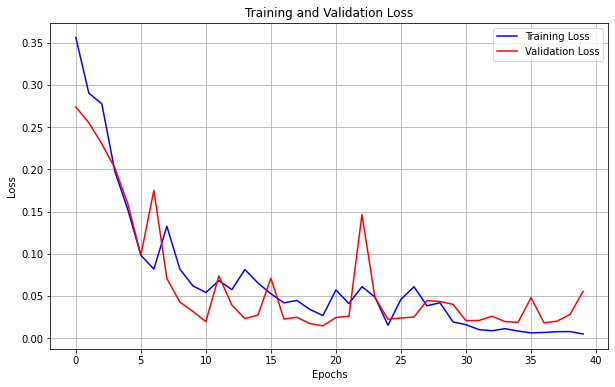

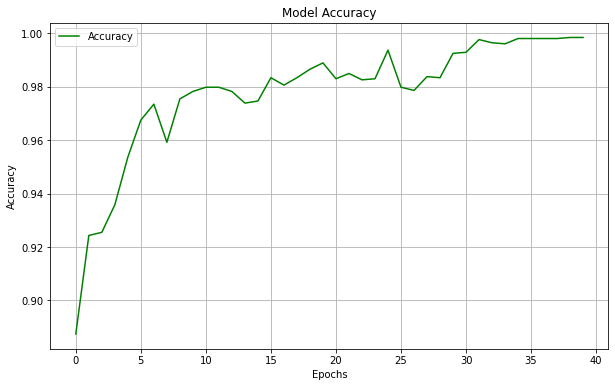

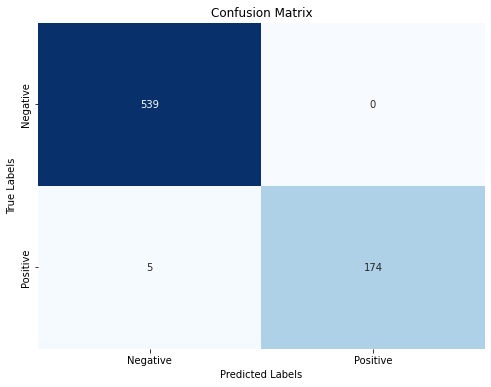

In [33]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(data=history.history['loss'], label='Training Loss', color='blue')
sns.lineplot(data=history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(data=history.history['accuracy'], label='Accuracy', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()




cm = confusion_matrix(test_labels, test_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
